# 0. 环境与数据 / Environment and Data

## 0.1 说明 / Description

本 Notebook 在 Kaggle 平台运行。
- Notebook 链接：[https://www.kaggle.com/code/yiquanxiao/cosmetics-e-commerce-eda-anomaly-analysis](https://www.kaggle.com/code/yiquanxiao/cosmetics-e-commerce-eda-anomaly-analysis)

---

This notebook runs on the Kaggle platform.
- Notebook Link: [https://www.kaggle.com/code/yiquanxiao/cosmetics-e-commerce-eda-anomaly-analysis](https://www.kaggle.com/code/yiquanxiao/cosmetics-e-commerce-eda-anomaly-analysis)

## 0.2 依赖 / Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from pathlib import Path

# 1. 数据准备 / Data Preparation

## 1.1 读取与合并 / Load & Merge

In [2]:
# 1.1.1 批量读取 / Batch Load
# 指定数据目录（根据实际路径调整）/ Adjust the path if needed
data_path = Path("/kaggle/input/ecommerce-events-history-in-cosmetics-shop")

# 匹配 5 个 CSV 文件 / Match the five CSV files
csv_files = {
    "2019-10": "2019-Oct.csv", 
    "2019-11": "2019-Nov.csv", 
    "2019-12": "2019-Dec.csv", 
    "2020-01": "2020-Jan.csv", 
    "2020-02": "2020-Feb.csv"
}
files_path = {}
for key, name in csv_files.items():
    files_path[key] = data_path / name


# 统一列类型 / Standardize dtypes before reading
dtype_map = {
    "event_type": "category",
    "product_id": "int64",
    "category_id": "int64",
    "category_code": "string",
    "brand": "string",
    "price": "float64",
    "user_id": "int64", 
}

dfs = []
for key, fp in files_path.items():
    df = pd.read_csv(
        fp,
        dtype=dtype_map,
        parse_dates=["event_time"]   # 直接解析时间列 / parse datetime column
    )
    df["year_month"] = key      # 标注来源文件 / track source file
    dfs.append(df)


# 1.1.2 纵向合并 / Vertical Concatenation
df_raw = pd.concat(dfs, ignore_index=True)
print(f"合并后数据量 / Total rows after concat: {df_raw.shape[0]:,}")

合并后数据量 / Total rows after concat: 20,692,840


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 10 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   event_type     category           
 2   product_id     int64              
 3   category_id    int64              
 4   category_code  string             
 5   brand          string             
 6   price          float64            
 7   user_id        int64              
 8   user_session   object             
 9   year_month     object             
dtypes: category(1), datetime64[ns, UTC](1), float64(1), int64(3), object(2), string(2)
memory usage: 1.4+ GB


In [4]:
df_raw.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,year_month
0,2019-10-01 00:00:00+00:00,cart,5773203,1487580005134238553,<NA>,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10
1,2019-10-01 00:00:03+00:00,cart,5773353,1487580005134238553,<NA>,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10
2,2019-10-01 00:00:07+00:00,cart,5881589,2151191071051219817,<NA>,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10
3,2019-10-01 00:00:07+00:00,cart,5723490,1487580005134238553,<NA>,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10
4,2019-10-01 00:00:15+00:00,cart,5881449,1487580013522845895,<NA>,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10


## 1.2 数据清洗 / Data Cleaning

In [5]:
# === 1.2.1 重复值检查 / Duplicates ===========================================
dedup_keys = ["event_time", "user_id", "product_id", "event_type"]
before_dupes = df_raw.shape[0]
df_raw.drop_duplicates(subset=dedup_keys, keep="first", inplace=True)
print(f"删除重复行 / Duplicates removed: {before_dupes - df_raw.shape[0]:,}")

删除重复行 / Duplicates removed: 1,120,960


In [6]:
# === 1.2.2 缺失值处理 / Missing Values ======================================
# -----------------------------
# 1) 构建映射字典 / Build mapping dicts
# -----------------------------
def build_mode_mapping(df, key_col, value_col):
    """
    返回: {product_id: 最常出现的value}
    Return a dict: product_id -> most frequent value for that column.
    """
    tmp = (
        df.dropna(subset=[key_col, value_col])
          .groupby(key_col)[value_col]
          .agg(lambda x: x.mode().iloc[0])  # 取众数 / take mode
    )
    return tmp.to_dict()

prod2cat = build_mode_mapping(df_raw, "product_id", "category_code")
prod2brand = build_mode_mapping(df_raw, "product_id", "brand")


# -----------------------------
# 2) 回填缺失 / Fill missing using mapping
# -----------------------------
# category_code
mask_cat_na = df_raw["category_code"].isna() | (df_raw["category_code"] == "")
before_fill_cat = mask_cat_na.sum()
df_raw.loc[mask_cat_na, "category_code"] = (
    df_raw.loc[mask_cat_na, "product_id"].map(prod2cat)
)

after_fill_cat = df_raw["category_code"].isna().sum() + (df_raw["category_code"] == "").sum()
filled_cat = before_fill_cat - after_fill_cat
print(f"category_code: fill {filled_cat} missing values")

# brand
mask_brand_na = df_raw["brand"].isna() | (df_raw["brand"] == "")
before_fill_brand = mask_brand_na.sum()
df_raw.loc[mask_brand_na, "brand"] = (
    df_raw.loc[mask_brand_na, "product_id"].map(prod2brand)
)

after_fill_brand = df_raw["brand"].isna().sum() + (df_raw["brand"] == "").sum()
filled_brand = before_fill_brand - after_fill_brand
print(f"brand: fill {filled_cat} missing values")


# -----------------------------
# 3) 统一剩余缺失值 / Fill remaining NAs with fallback labels
# -----------------------------
df_raw["category_code"] = df_raw["category_code"].fillna("beauty_unknown")
df_raw["brand"] = df_raw["brand"].fillna("unknown_brand")

category_code: fill 1786 missing values
brand: fill 1786 missing values


[可选步骤] 移除时区信息 / [Optional Step] Remove timezone information (if present)

在电商数据分析中，我们通常按天、周、月聚合数据（如 GMV、留存率等）。时区对这些周期性统计结果影响很小，特别是当数据源已经标准化到 UTC 时。因此，为了简化后续操作，我们可以去掉时区信息。

In e-commerce data analysis, we usually aggregate data by day, week, or month (e.g., GMV, retention rates). Timezone differences have little impact on these metrics, especially if the data is already standardized to UTC. Therefore, we can safely remove the timezone information to simplify processing.

In [7]:
# Optional
df['event_time'] = df['event_time'].dt.tz_localize(None)

In [8]:
# === 1.2.3 时间解析 & 衍生列 / Time Parsing & Derived Columns ================
# event_date: 将时间截断到“天”，但保留 datetime64 dtype
# Normalize to midnight, keep dtype = datetime64[ns].
df_raw["event_date"] = df_raw["event_time"].dt.normalize()  
df_raw["event_month"] = df_raw["event_time"].dt.to_period("M")  
df_raw["event_weekday"] = df_raw["event_time"].dt.day_name()
df_raw["hour_bin"] = df_raw["event_time"].dt.hour // 4  # 6 个 4h 时段 / six 4‑h bins

/tmp/ipykernel_13/3471177408.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_raw["event_month"] = df_raw["event_time"].dt.to_period("M")


In [9]:
# === 1.2.4 行为编码 / Event Encoding ========================================
event_dummies = pd.get_dummies(df_raw["event_type"], prefix="is")
df_raw = pd.concat([df_raw, event_dummies], axis=1)

In [10]:
# === 1.2.5 清理无效价格 / Remove Invalid Prices ==============================
# 检查是否存在价格小于0的异常记录 / Check for abnormal records where price < 0
negative_prices = df_raw[df_raw['price'] < 0]
print(f"Number of negative price records: {len(negative_prices)}")

# 删除价格为负的记录，并重置索引 / Remove records with negative price values and reset the index
df_raw = df_raw[df_raw['price'] >= 0].reset_index(drop=True)

Number of negative price records: 124


In [11]:
# # === 1.2.6 会话划分 / Sessionization ========================================
# # Sort data for sessionization
# df_raw.sort_values(["user_id", "event_time"], inplace=True)

# # 计算与上一条记录的时间差 / time delta from previous event
# df_raw["prev_time"] = df_raw.groupby("user_id")["event_time"].shift()
# df_raw["gaptime_min"] = (
#     (df_raw["event_time"] - df_raw["prev_time"]).dt.total_seconds() / 60
# )

# # 标记新会话：gap > 30 min 或用户第一次出现
# df_raw["new_session_flag"] = (
#     (df_raw["gaptime_min"].isna()) | (df_raw["gaptime_min"] > 30)
# ).astype(int)

# # 累积新会话计数 / cumulative session counter
# df_raw["session_idx"] = df_raw.groupby("user_id")["new_session_flag"].cumsum()

# # 生成 session_id / Create a unique session_id
# df_raw["session_id"] = (
#     df_raw["user_id"].astype(str) + "_" + df_raw["session_idx"].astype(str)
# )

# # 清理临时列 / drop temp helpers
# df_raw.drop(columns=["prev_time", "gaptime_min", "new_session_flag"], inplace=True)

In [12]:
df_raw.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,year_month,event_date,event_month,event_weekday,hour_bin,is_cart,is_purchase,is_remove_from_cart,is_view
0,2019-10-01 00:00:00+00:00,cart,5773203,1487580005134238553,beauty_unknown,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10,2019-10-01 00:00:00+00:00,2019-10,Tuesday,0,True,False,False,False
1,2019-10-01 00:00:03+00:00,cart,5773353,1487580005134238553,beauty_unknown,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10,2019-10-01 00:00:00+00:00,2019-10,Tuesday,0,True,False,False,False
2,2019-10-01 00:00:07+00:00,cart,5881589,2151191071051219817,beauty_unknown,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10,2019-10-01 00:00:00+00:00,2019-10,Tuesday,0,True,False,False,False
3,2019-10-01 00:00:07+00:00,cart,5723490,1487580005134238553,beauty_unknown,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10,2019-10-01 00:00:00+00:00,2019-10,Tuesday,0,True,False,False,False
4,2019-10-01 00:00:15+00:00,cart,5881449,1487580013522845895,beauty_unknown,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10,2019-10-01 00:00:00+00:00,2019-10,Tuesday,0,True,False,False,False


# 2. 探索性分析 / Exploratory Data Analysis (EDA)

## 2.1 基础指标 / Basic KPIs

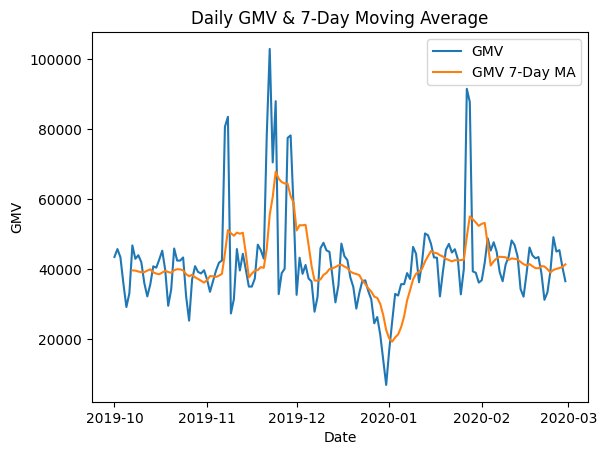

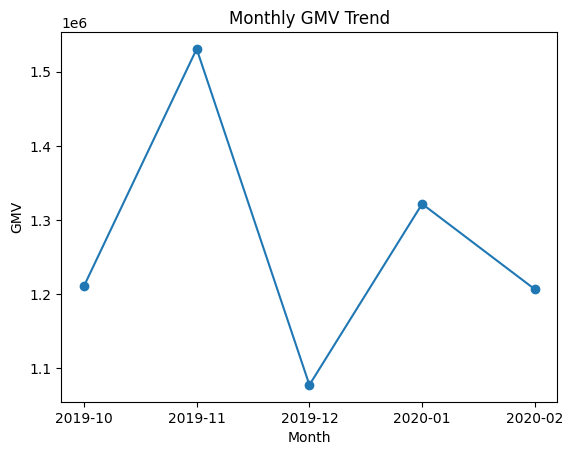

In [13]:
# === 2.1.1 日度指标 / Daily KPIs =======================================
purchase = df_raw[df_raw['is_purchase'] == 1].copy()
daily_kpi = purchase.groupby('event_date').agg(
    gmv=('price', 'sum'),
    orders=('is_purchase', 'sum'),
    unique_buyers=('user_id', 'nunique')
)
daily_kpi['aov'] = daily_kpi['gmv'] / daily_kpi['orders']
daily_kpi.sort_index(inplace=True)

plt.figure()
plt.plot(daily_kpi.index, daily_kpi['gmv'], label='GMV')
plt.plot(daily_kpi.index, daily_kpi['gmv'].rolling(7).mean(), label='GMV 7-Day MA')
plt.title('Daily GMV & 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('GMV')
plt.legend()
plt.show()

# === 2.1.2 月度指标 / Monthly KPIs ====================================
monthly_kpi = purchase.groupby('event_month').agg(
    gmv=('price', 'sum'),
    orders=('is_purchase', 'sum'),
    unique_buyers=('user_id', 'nunique')
)
monthly_kpi['aov'] = monthly_kpi['gmv'] / monthly_kpi['orders']
monthly_kpi.sort_index(inplace=True)

plt.figure()
plt.plot(monthly_kpi.index.astype(str), monthly_kpi['gmv'], marker='o')
plt.title('Monthly GMV Trend')
plt.xlabel('Month')
plt.ylabel('GMV')
plt.show()

### 洞察（GMV） / Insights (GMV)

从日度和月度 GMV 趋势图来看，**2019 年 11 月 GMV 出现了异常暴涨，而 12 月则显著下滑**。这种大幅波动很可能是由于 11 月的**黑色星期五**活动刺激了用户的集中购买行为，导致 11 月 GMV 冲高，但 12 月消费需求被提前释放，因此 GMV 明显回落。

从 2020 年 1 月和 2 月的走势看，GMV 已逐渐回升至 10 月的常规水平，说明 11 月促销高峰的后续影响正在消退。
不过，这一假设仍需结合后续异动分析来进一步验证，以确认 GMV 波动是由活动因素驱动还是存在其他潜在异常。

---

The daily and monthly GMV trends indicate **a sharp surge in November 2019, followed by a steep decline in December**. This fluctuation is likely driven by **Black Friday promotions in November**, which concentrated customer purchases into that month, resulting in a significant drop in December as demand had already been pulled forward.
By January and February 2020, GMV recovered to around the October baseline, suggesting that the impact of the November sales peak gradually faded.

However, this hypothesis needs further validation through **anomaly analysis**, e.g., examining changes in traffic (views), conversion rates, and average order value (AOV) to confirm whether the spike and drop were purely due to promotions or if other anomalies were involved.

## 2.2 品牌 & 价格分布 / Brand & Price Distribution

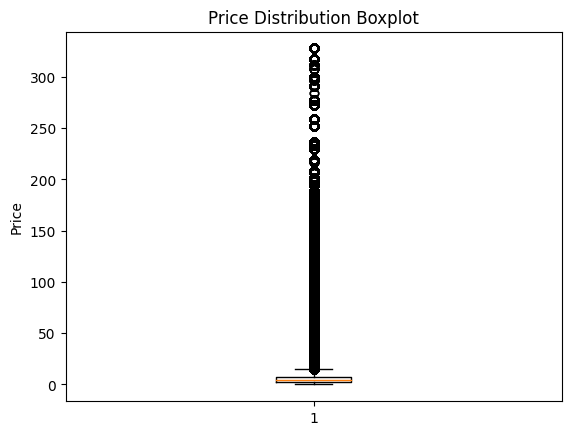

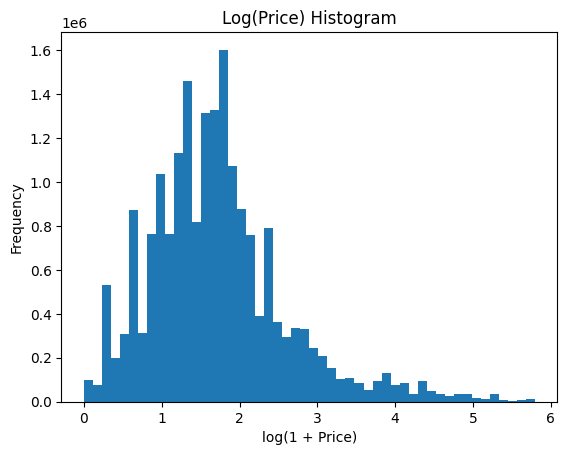

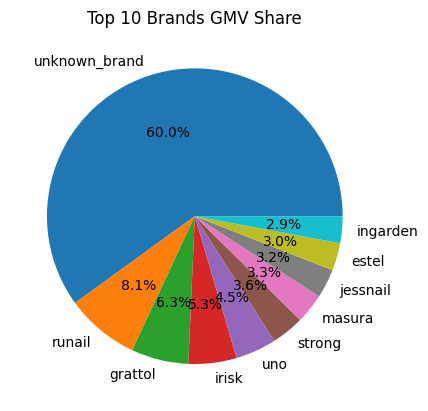

In [14]:
plt.figure()
plt.boxplot(df_raw['price'].dropna())
plt.title('Price Distribution Boxplot')
plt.ylabel('Price')
plt.show()

plt.figure()
plt.hist(np.log1p(df_raw['price']), bins=50)
plt.title('Log(Price) Histogram')
plt.xlabel('log(1 + Price)')
plt.ylabel('Frequency')
plt.show()

brand_gmv = purchase.groupby('brand')['price'].sum().sort_values(ascending=False).head(10)
plt.figure()
plt.pie(brand_gmv.values, labels=brand_gmv.index, autopct='%1.1f%%')
plt.title('Top 10 Brands GMV Share')
plt.show()

In [15]:
df_raw['price'].describe()

count    1.957176e+07
mean     8.736007e+00
std      1.975049e+01
min      0.000000e+00
25%      2.110000e+00
50%      4.110000e+00
75%      7.140000e+00
max      3.277800e+02
Name: price, dtype: float64

### 洞察（价格） / Insights (Price)

1. **价格分布高度右偏**
   * 从原始数据来看，价格均值约为 **8.7**，但标准差较大（约 **19.8**），最大值高达 **327.8**，说明存在较少的高价商品拉高了均值。
   * 使用 `log(1 + price)` 转换后，直方图呈现更接近正态的分布，主要集中在 `log(1+price) ∈ [1, 2]`（对应价格大约在 2.7 到 6.4 左右）。

2. **主流商品价格区间较低**
   * 从四分位数看，**75% 的商品价格低于 7.14**，而 50% 的商品价格低于 4.11，表明平台上主要商品集中在低价区间。
  
3. **需要关注高价商品对 GMV 的贡献**
   * 虽然高价商品数量少，但可能对 GMV 有较大影响，后续可考虑 **分价位分析 GMV 和转化率**，看高价商品是否有更高的平均客单价贡献。
  
---

1. **Right-Skewed Distribution**
   * The price distribution is **highly right-skewed**. The mean price is around **8.7**, but the large standard deviation (**19.8**) and a maximum value of **327.8** indicate a small number of high-priced products skewing the average.
   * After applying `log(1 + price)` transformation, the distribution becomes closer to normal, with most prices concentrated between `log(1+price) ∈ [1, 2]` (approx. 2.7–6.4 in original price).

2. **Majority of products are low-priced**
   * The 75th percentile is **7.14**, and the median price is **4.11**, indicating that **most products are in the low-price range**.

3. **High-priced products may impact GMV disproportionately**
   * While high-priced products are few, they may disproportionately influence GMV. A **price-segment analysis of GMV and conversion rates** is recommended to assess their contribution.

## 2.3 Cohort 留存 / Cohort Retention

In [16]:
# first_purchase = purchase.groupby('user_id')['event_date'].min().apply(lambda x: x.to_period('M'))
# purchase = purchase.assign(cohort_month=purchase['user_id'].map(first_purchase))
# purchase = purchase.assign(purchase_month=purchase['event_date'].apply(lambda x: x.to_period('M')))
# cohort_counts = purchase.groupby(['cohort_month', 'purchase_month'])['user_id'].nunique().unstack(fill_value=0)
# cohort_sizes = cohort_counts.iloc[:, 0:].apply(lambda row: row[row.index == row.name].values[0], axis=1)
# retention = cohort_counts.div(cohort_sizes, axis=0)


# plt.figure()
# plt.imshow(retention, aspect='auto')
# plt.title('Cohort Retention Rates')
# plt.xlabel('Months Since First Purchase')
# plt.ylabel('Cohort Month')
# plt.xticks(range(retention.shape[1]), labels=range(retention.shape[1]))
# plt.yticks(range(retention.shape[0]), labels=retention.index.astype(str))
# plt.colorbar(label='Retention Rate')
# plt.show()

/tmp/ipykernel_13/4134186477.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  purchase['purchase_month'] = purchase['event_date'].dt.to_period('M')


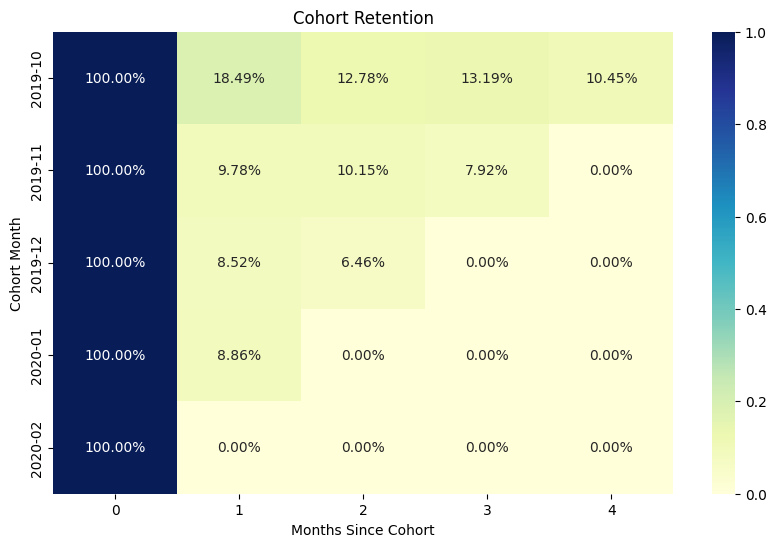

In [17]:
# 2.3.1. 计算每个用户的首购月份 / Calculate the first purchase month for each user
first_purchase = purchase.groupby('user_id')['event_month'].min()


# 2.3.2. 为每笔订单标记 cohort_month 和 purchase_month
# Assign cohort_month (user’s first purchase month) and purchase_month
purchase['cohort_month'] = purchase['user_id'].map(first_purchase)
purchase['purchase_month'] = purchase['event_date'].dt.to_period('M')


# 2.3.3. 计算距离首购月的月份差 / Calculate months since the cohort start (period_index)
purchase['period_index'] = (purchase['purchase_month'] - purchase['cohort_month']).apply(lambda x: x.n)


# 2.3.4. 构建 Cohort 表格 / Build cohort matrix (unique users per cohort per month)

# 统计每个 cohort (cohort_month) 在每个 period_index 下的唯一用户数量
# Count unique users for each cohort and period index
cohort_data = purchase.groupby(['cohort_month', 'period_index'])['user_id'].nunique().unstack(fill_value=0)


# 2.3.5. 计算留存率矩阵 / Calculate retention rates

# 每个 cohort 的首月用户数（作为基准）/ Get the first month user count for each cohort
cohort_sizes = cohort_data.iloc[:, 0]

# 留存率 = 每月用户数 / 首月用户数
# Retention rate = users in month / users in first month
retention = cohort_data.divide(cohort_sizes, axis=0)

# 2.3.6. 可视化留存热力图 / Visualize retention heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    retention,
    annot=True,
    fmt=".2%",
    cmap="YlGnBu",
    cbar=True
)
plt.title('Cohort Retention')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since Cohort')
plt.show()

### 洞察（留存） / Insights (Retention)

1. **首月留存普遍 $\approx$ 9%，唯独 2019‑10 Cohort 异常高（18.49%）**

   * 其他 Cohort 在 M1（首购后第 1 个月）几乎都跌到 9% 左右。
   * 2019‑10 的 M1 留存远高于均值，极可能受 11 月黑五大促刺激了二次购买。

2. **2019‑10 Cohort 后续月份留存也更高**

   * 在 M2–M4，这个 Cohort 的留存仍显著高于同时期其他 Cohort，说明一次大型折扣可能带来更长期的粘性提升。

3. **长期留存接近 0，复购周期短**

   * 多数 Cohort 在第 3 个月后几乎没有留存，说明用户大多“一锤子买卖”，缺乏持续复购。

4. **不同 Cohort 下降轨迹相似，缺少改善迹象**

   * 除了 2019‑10 Cohort 的黑五效应，其余 Cohort 的曲线都快速衰减，表明现有留存策略未显著起效。

---

1. **Month‑1 retention is $\approx$ 9% overall; only the Oct‑2019 cohort spikes to 18.49%**

   * Most cohorts drop to around 9% by Month 1 (M1).
   * The Oct‑2019 cohort’s unusually high M1 retention likely comes from Black Friday promotions in November that drove second purchases.

2. **Oct‑2019 cohort sustains higher retention in later months**

   * Its M2–M4 retention stays above other cohorts, suggesting a major discount can create longer-lasting stickiness.

3. **Near-zero long-term retention indicates short customer life cycles**

   * After Month 3, retention is almost zero for most cohorts, implying purchases are largely one-off.

4. **Similar declining patterns across cohorts—no sign of improvement**

   * Except for the Black Friday cohort, curves drop steeply, indicating current retention tactics are ineffective.

#### 可执行建议 / Actionable Ideas

1. **首月二次购激励**：首购后 7–14 天发放高额限时券或包邮，目标把常规 Cohort 的 M1 留存提升到 12–15%。
2. **集中资源做大促并做好“尾部运营”**：削减日常小折扣，把预算集中到黑五/双十一等节点，并在活动后 2–4 周强化再营销。
3. **复制黑五效应给非促期新客**：为非大促期新用户设计“首购券 + 首月复购券”组合，模拟一次“大折扣→长期留存”的路径。

---

1. **Incentivize second purchases within Month 1:** Send sizable, time-limited vouchers or free-shipping offers 7–14 days post–first purchase to lift M1 retention to 12–15%.
2. **Shift budget to major campaigns + long-tail remarketing:** Reduce scattered small discounts; invest in big events like Black Friday and sustain remarketing for 2–4 weeks afterwards.
3. **Replicate the “big-promo effect” for off-peak cohorts:** Bundle a first-purchase coupon with a Month‑1 repurchase coupon to mimic the retention boost seen in the Black Friday cohort.

## 2.4 漏斗分析 / Funnel Analysis

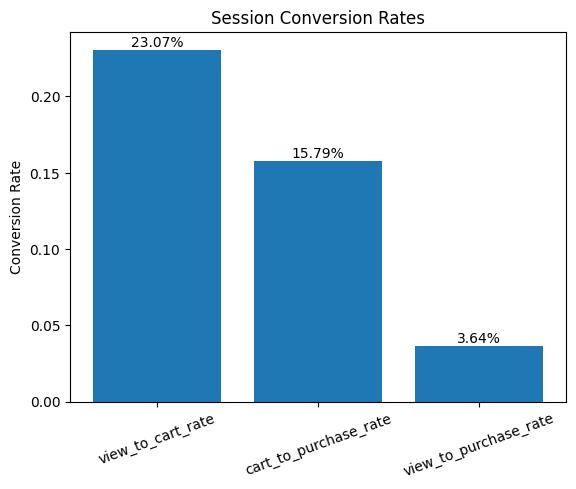

In [18]:
# === 2.4.1. 转化率柱状图 / bar chart of conversion rates =======================

# 聚合每个 session 的行为：是否浏览、是否加购、是否购买
# Aggregate user sessions to check if view/cart/purchase occurred
session_funnel = df_raw.groupby('user_session').agg({
    'is_view': 'max',
    'is_cart': 'max',
    'is_purchase': 'max'
})

# 各阶段的总数量
# Total number of sessions that include each stage
funnel_counts = session_funnel.sum()

# 计算三种转化率
# Calculate add-to-cart, checkout, and overall conversion rates
funnel_rates = pd.Series({
    # 整体下单转化率 / view-to-cart rate
    'view_to_cart_rate': funnel_counts['is_cart'] / funnel_counts['is_view'],
    # 加购率 / cart-to-purchasey rate
    'cart_to_purchase_rate': funnel_counts['is_purchase'] / funnel_counts['is_cart'],
    # 结账转化率 / view-to-cart rate
    'view_to_purchase_rate': funnel_counts['is_purchase'] / funnel_counts['is_view']
})

# 可视化：柱状图
# Visualization: bar chart of conversion rates
plt.figure()
bars = plt.bar(funnel_rates.index, funnel_rates.values)
plt.title('Session Conversion Rates')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=20)

# 在柱子上标注百分比 / add percentage above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x坐标：柱子中间 / x-position: middle of the bar
        height,  # y坐标：柱子顶端 / y-position: above the bar
        f"{height:.2%}",  # 格式化为百分比 / show as percentage
        ha='center', va='bottom'
    )

plt.show()

### 洞察（会话转化率） / Insights (Session Conversion)

1. **加购→购买是主要瓶颈**

   * 仅 **15.79 %** 的购物车完成结账，说明结账流程或价格因素导致大量流失。
2. **整体下单转化率偏低**

   * 访问到下单仅 **3.64 %**，提升任一环节都能放大 GMV。

---

1. **Cart → Purchase is the key bottleneck**

   * Only **15.79 %** of carts convert, indicating checkout friction or price sensitivity.
2. **Overall conversion is low**

   * View‑to‑purchase is just **3.64 %**; improving any step would boost GMV.


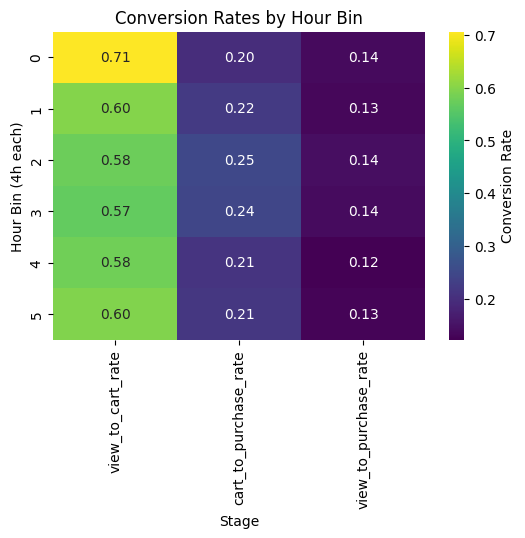

In [19]:
# === 2.4.2. 小时段 × 转化率热力图 / heatmap of hour_bin × conversion rates ======
# 按小时段统计每个阶段的数量 / Aggregate stage counts by hour bin
hourly_stage_counts = df_raw.groupby('hour_bin').agg({
    'is_view': 'sum',
    'is_cart': 'sum',
    'is_purchase': 'sum'
})

# 计算每个小时段的转化率（加购率、结账转化率、整体下单转化率）
# Calculate conversion rates per hour bin (add-to-cart, checkout, overall conversion)
hourly_conversion_rates = pd.DataFrame({
    # 整体下单转化率 / view-to-cart rate
    'view_to_cart_rate': hourly_stage_counts['is_cart'] / hourly_stage_counts['is_view'],
    # 加购率 / cart-to-purchasey rate
    'cart_to_purchase_rate': hourly_stage_counts['is_purchase'] / hourly_stage_counts['is_cart'],
    # 结账转化率 / view-to-cart rate
    'view_to_purchase_rate': hourly_stage_counts['is_purchase'] / hourly_stage_counts['is_view']
})

plt.figure(figsize=(6,4))
sns.heatmap(
    hourly_conversion_rates,
    annot=True,            
    fmt=".2f",             
    cmap="viridis",        
    cbar_kws={'label': 'Conversion Rate'}
)
plt.title('Conversion Rates by Hour Bin')
plt.xlabel('Stage')
plt.ylabel('Hour Bin (4h each)')
plt.show()

### 洞察（小时段 × 转化率） / Insights (Conversion by Hour Bin)

1. **凌晨 0–4 点加购率最高，结账率最低**

   * `view→cart` = 0.71，显著高于日间；`cart→purchase` 仅 0.20，深夜用户多加购但推迟付款。
2. **上午 8–12 点结账效率最佳**

   * `cart→purchase` = 0.25 为全天峰值；`view→purchase` = 0.14，早间成为“理性下单”高峰。
3. **傍晚 16–20 点整体转化偏低**

   * 三项指标齐跌（`view→purchase` ≈ 0.12），或因通勤与注意力分散。
4. **整日 `view→purchase` 相对平稳 (0.12–0.14)**

   * 总体转化差异主要集中在“加购后是否支付”环节。

---

1. **Highest add‑to‑cart in 0–4 AM, but lowest checkout**

   * `view→cart` = 0.71; `cart→purchase` = 0.20—users add at night but delay payment.
2. **Best checkout efficiency in 8–12 AM**

   * `cart→purchase` = 0.25 (day high); `view→purchase` = 0.14, a rational morning buying window.
3. **Weaker conversion in 4–8 PM**

   * All metrics dip (`view→purchase` ≈ 0.12) likely due to commute‑time distraction.
4. **Overall `view→purchase` steady at 0.12–0.14**

   * Main variance lies in the cart‑to‑purchase step.

### 建议 / Recommendations

* **针对深夜高加购低付款**

  * 在 0–4 点自动推送“立即结账立减”或包邮券。
  * 开启快捷支付通道，简化夜间结账流程。
* **放大上午结账高峰**

  * 8–11 点推出限时优惠或免邮活动，强化购买冲动。
  * 发送“昨晚加购未付款”提醒，引导用户完成支付。
* **弥补傍晚转化低谷**

  * 下班前推送“优惠即将结束”通知，制造紧迫感。
  * 18 点上线闪购/秒杀，提高用户停留与转化。

---

* **Address high add‑to‑cart but low checkout at night**

  * Push instant‑checkout coupons or free‑shipping offers between 0–4 AM.
  * Enable one‑click payment to streamline late‑night checkout.
* **Leverage the morning checkout peak**

  * Run limited‑time or free‑shipping promos from 8–11 AM.
  * Send “items still in cart” reminders to prompt completion.
* **Mitigate the evening conversion dip**

  * Push “offer ending soon” alerts before commute finishes.
  * Launch flash deals around 6 PM to boost engagement and conversion.

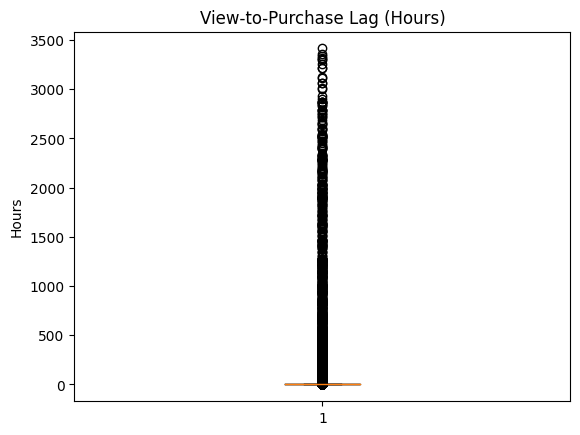

In [20]:
# === 2.4.3. 浏览到购买的时间差 / View-to-Purchase Lag =======================
view_times = (
    df_raw[df_raw['is_view'] == 1]
    .groupby('user_session')['event_time']
    .min()
    .rename('view_time')
)

purchase_times = (
    df_raw[df_raw['is_purchase'] == 1]
    .groupby('user_session')['event_time']
    .min()
    .rename('purchase_time')
)

lag_df = pd.merge(view_times, purchase_times, on='user_session', how='inner')
lag_df['lag_hours'] = (lag_df['purchase_time'] - lag_df['view_time']).dt.total_seconds() / 3600
lag = lag_df.loc[lag_df['lag_hours'] >= 0, 'lag_hours']

plt.figure()
plt.boxplot(lag)
plt.title('View-to-Purchase Lag (Hours)')
plt.ylabel('Hours')
plt.show()

In [21]:
lag.describe()

count    114126.000000
mean          8.492271
std         108.443753
min           0.000000
25%           0.120000
50%           0.283056
75%           0.671667
max        3414.218611
Name: lag_hours, dtype: float64

### 洞察（浏览→购买时滞） / Insights (View‑to‑Purchase Lag)

1. **绝大多数转化发生在浏览后 30 分钟内**

   * 中位数 **0.28 小时 ≈ 17 分钟**，75 分位仅 **0.67 小时**，说明 75 % 的订单在 40 分钟内完成。
2. **长尾异常值极多**

   * 最大时滞 **3414 小时（≈ 142 天）**，导致均值偏离（8.49 小时）且标准差高达 108 小时；均值和标准差已失去代表性。
3. **离群用户可能包含反复比较或多设备场景**

   * 超长时滞订单值得进一步抽样，排查重复浏览、跨设备或数据记录问题。

---

1. **Most conversions happen within 30 minutes of view**

   * Median lag is **0.28 h ≈ 17 min**, and the 75th percentile is **0.67 h**, meaning 75 % of purchases complete within 40 minutes.
2. **Heavy long‑tail outliers**

   * The maximum lag reaches **3414 h (\~ 142 days)**, inflating the mean (8.49 h) and SD (108 h); mean/SD are thus not informative.
3. **Extreme lags may stem from comparison shopping or cross‑device behavior**

   * Sampling these orders could reveal repeated browsing, device switching, or data anomalies.

### 建议 / Recommendations

* 聚焦 **0–1 小时窗口**：针对已浏览未购用户，在 30 分钟内推送提醒或优惠券，提升即时转化。
* 对长尾订单做 **异常检测**：抽样核查超 24 小时时滞的订单，排除日志问题或识别高潜力犹豫用户。
* 营销分层：快速转化用户用即时激励，慢转化群体结合再营销广告与邮件跟进。

---

* **Target the 0–1 hour window:** Send reminders or coupons within 30 minutes of view to boost immediate conversion.
* **Outlier auditing:** Sample orders with lags > 24 h to rule out logging issues and identify deliberative shoppers.
* **Segmented marketing:** Use instant incentives for fast converters; deploy retargeting ads and emails for slow converters.

# 3. 异动分析 / Anomaly Analysis

## 3.1 月度转化率拆解 / Conversion Rate Breakdown

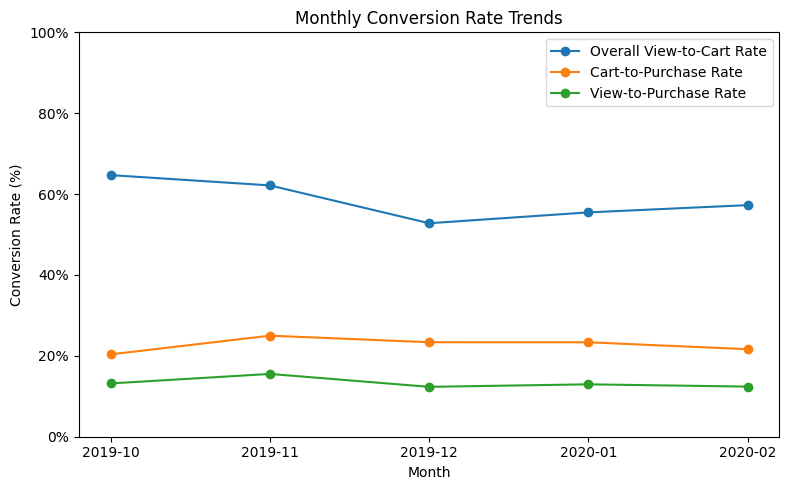

In [22]:
# === 月度转化率趋势 / Monthly Conversion Rate Trends ===============

# 按月汇总各阶段事件计数 / Aggregate counts by event_month
monthly_stage_counts = df_raw.groupby('event_month').agg({
    'is_view': 'sum',
    'is_cart': 'sum',
    'is_purchase': 'sum'
})

# 计算转化率 / Calculate conversion rates
monthly_conversion_rates = pd.DataFrame({
    'view_to_cart_rate': monthly_stage_counts['is_cart'] / monthly_stage_counts['is_view'],
    'cart_to_purchase_rate': monthly_stage_counts['is_purchase'] / monthly_stage_counts['is_cart'],
    'view_to_purchase_rate': monthly_stage_counts['is_purchase'] / monthly_stage_counts['is_view']
})

# 绘制折线图 / Plot line chart of monthly conversion rates
plt.figure(figsize=(8, 5))
plt.plot(
    monthly_conversion_rates.index.astype(str),
    monthly_conversion_rates['view_to_cart_rate'],
    marker='o', label='Overall View‑to‑Cart Rate'  # 整体下单转化率
)
plt.plot(
    monthly_conversion_rates.index.astype(str),
    monthly_conversion_rates['cart_to_purchase_rate'],
    marker='o', label='Cart‑to‑Purchase Rate'  # 加购转化率
)
plt.plot(
    monthly_conversion_rates.index.astype(str),
    monthly_conversion_rates['view_to_purchase_rate'],
    marker='o', label='View‑to‑Purchase Rate'  # 结账转化率
)

# 图表美化 / Enhance plot
plt.title('Monthly Conversion Rate Trends')
plt.xlabel('Month')
plt.ylabel('Conversion Rate (%)')
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # 百分比格式 / percentage
# plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### 洞察（月度转化率趋势） / Insights (Monthly Conversion Rate Trends)

1. **三条转化率曲线整体平稳**

   * 加购转化率（蓝）在 52 %–65 % 区间，12 月虽略降但 1 月后逐步回升。
   * 结账转化率（橙）维持在 21 %–25 %，变化幅度＜4 pp。
   * 整体下单转化率（绿）始终在 12 %–15 % 之间，无明显异常跳水。
2. **12 月 GMV 暴降并非由转化率下滑驱动**

   * 与 11 月相比，12 月三项转化率仅小幅波动，不足以解释 GMV 的大幅回落。
   * 佐证此前假设——12 月需求被 11 月黑五“透支”，而非漏斗效率恶化。
3. **1–2 月转化率继续回稳**

   * 说明黑五活动的短期扰动已消散，平台漏斗效率恢复常态。

---

1. **All three conversion rates are broadly stable**

   * View‑to‑cart ranges **52 %–65 %**; slight dip in Dec but rebounds afterward.
   * Cart‑to‑purchase stays **21 %–25 %** with < 4 pp fluctuation.
   * View‑to‑purchase remains **12 %–15 %**, showing no sharp drop.
2. **Dec‑19 GMV plunge is not conversion‑driven**

   * Minor rate changes vs. Nov cannot account for the GMV decline, reinforcing the “demand pulled forward by Black Friday” hypothesis.
3. **Conversion rates normalize in Jan–Feb**

   * Indicates the Black Friday shock was temporary; funnel efficiency has returned to baseline.


## 3.2 浏览量变化分析 / Traffic (Views) Analysis

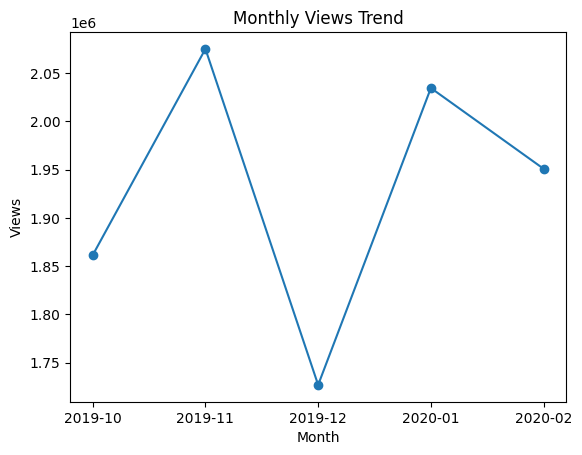

In [23]:
# === 每月浏览量 / Monthly Views ====================================
monthly_views = df_raw.groupby('event_month')['is_view'].sum()

plt.figure()
plt.plot(monthly_views.index.astype(str), monthly_views.values, marker='o')
plt.title('Monthly Views Trend')
plt.xlabel('Month')
plt.ylabel('Views')
plt.show()

### 洞察（浏览量趋势） / Insights (Monthly Views Trend)

1. **11 月流量峰值 → 12 月骤降**

   * 浏览量从 11 月 2.07 M 跌至 12 月 1.73 M，环比‑16 %，也低于 10 月基线，验证“黑五透支需求”假设。
2. **流量波动与 GMV 走势高度一致**

   * 12 月 GMV 暴跌主要由流量下滑驱动，而转化率保持平稳；1 月流量恢复至 2.03 M，GMV 随之回升。
3. **促销后存在“反弹‑回落”效应**

   * 黑五带来短期流量峰值，紧随其后出现流量低谷，再逐步回归常态，提示需关注促销后的流量空窗期。

---

1. **Traffic peaks in Nov, plunges in Dec**

   * Views drop from 2.07 M (Nov) to 1.73 M (Dec), a ‑16 % MoM fall and below the Oct baseline—supporting the “demand pulled forward by Black Friday” thesis.
2. **Traffic swing mirrors GMV pattern**

   * The Dec GMV dive is traffic‑driven; conversion rates stayed steady. When views rebound to 2.03 M in Jan, GMV likewise recovers.
3. **Post‑promo “spike‑dip” effect**

   * Black Friday yields a short‑lived traffic spike followed by a trough that slowly normalizes, highlighting the need to manage the post‑promotion lull.

## 3.3 客单价变化分析 / AOV Analysis

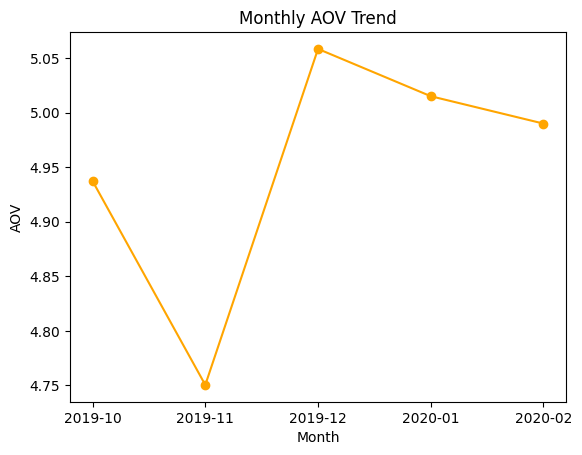

In [24]:
# === 每月平均客单价 / Monthly AOV ====================================
plt.figure()
plt.plot(monthly_kpi.index.astype(str), monthly_kpi['aov'], marker='o', color='orange')
plt.title('Monthly AOV Trend')
plt.xlabel('Month')
plt.ylabel('AOV')
plt.show()

### 洞察（客单价 AOV）

1. **总体稳定在≈ 5 元区间**

   * 10 月‑2 月 AOV 变化范围仅 4.75–5.05，波动＜ 6 %。
2. **11 月 AOV 小幅下探至 4.75**

   * 与黑五大促的普遍折扣相符；12 月即反弹至 5.05，说明降价影响短暂。
3. **AOV 走势对 GMV 影响有限**

   * 12 月 GMV 暴跌时 AOV 反而升高，进一步证明 GMV 下滑主要由浏览量不足，而非客单价下降导致。

---

### Insights (Average Order Value)

1. **Overall stable around ≈ 5**

   * AOV ranges 4.75–5.05 from Oct to Feb, < 6 % variance.
2. **Slight dip to 4.75 in Nov**

   * Consistent with Black‑Friday discounts; rebounds to 5.05 in Dec, indicating the price cut was short‑lived.
3. **AOV not a key GMV driver**

   * GMV plunges in Dec while AOV rises, confirming the decline was traffic‑driven rather than ticket‑size‑driven.


## 3.4 结论 / Summary  

- 12 月 GMV 环比 ‑30 % 的主要原因是浏览量下降 16 %，而转化率和 AOV 保持正常波动。  
- 造成流量下滑的关键事件是 11 月黑五大促：需求被前置，12 月进入“淡季”。  
- 1 月 GMV 与流量同步回升，进一步验证这是季节性波动。


> **结论**：12 月 GMV 暴降属于 **可预期的促销季后效应**，不构成业务异常；后续应关注大型活动后的流量空窗期，并在淡季通过再营销或新品补量。

--- 
 
- December GMV fell 30 % MoM mainly because views dropped 16 %; conversion rates and AOV stayed within normal ranges.  
- The traffic dip follows November’s Black Friday spike—demand was simply pulled forward.  
- GMV rebounds in January alongside traffic, confirming a seasonal pattern rather than an operational anomaly.

> **Conclusion**: The December drop is a predictable post‑promotion effect; focus on mitigating the post‑campaign traffic lull through remarketing and product refresh.